In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
# import bayes3d.genjax
# import genjax
import pathlib
import numpy as np
import PIL

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7037/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=20.0
)


b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [215]:
IDX = 15
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

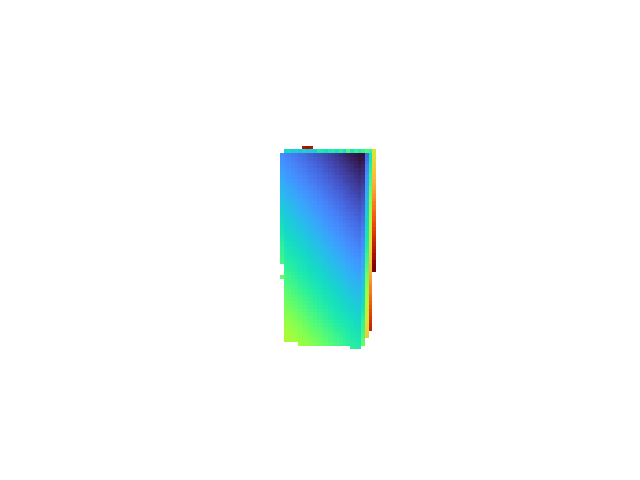

(38, 28)
(37, 27)


In [216]:
%matplotlib widget
img = b.RENDERER.render(table_pose[None,...], jnp.array([IDX]))
fig, axes = plt.subplots()
b.add_depth_image(axes,img[...,2])
location = (37, 49)
def onclick(event):
    global location
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))
    location = (x,y)
    print(location)
    axes.axis("on")
    axes.scatter(x,y, c='r', marker="x", s=200)

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [217]:
coordinate = img[location[1],location[0],:3]
coordinate_in_object_frame = b.apply_transform(coordinate.reshape(-1,3), b.t3d.inverse_pose(table_pose))[0]


random_poses = jax.vmap(
    b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(
        jax.random.split(jax.random.PRNGKey(10),4000), table_pose, 0.05, 1.0)
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), random_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

images = b.RENDERER.render_many(random_poses[:,None,...], jnp.array([IDX]))
rendered_points = images[jnp.arange(images.shape[0]), pixel_coordinates[:,1], pixel_coordinates[:,0], :]
distances = jnp.linalg.norm(rendered_points[...,:3]- coordinates[:,:3],axis=-1)
valid_indices = distances < 0.005
images_subset = images[valid_indices]
pixel_coordinates_subset = pixel_coordinates[valid_indices]


filter_size = 6
get_patch = lambda image, coordinate: jax.lax.dynamic_slice(image,
    (coordinate[1]-filter_size, coordinate[0]-filter_size, 0),
    (2*filter_size+1,2*filter_size+1,4))

patches = jax.vmap(get_patch)(images_subset, pixel_coordinates_subset)
patches_centered = jnp.concatenate([patches[...,:3] - patches[:,filter_size,filter_size,:][...,None,None,:3],patches[...,3][...,None]],axis=-1)

valid_indices = jnp.abs(patches_centered[:,:,2]).sum(-1).sum(-1) > 1e-4
images_subset = images_subset[valid_indices]
pixel_coordinates_subset = pixel_coordinates_subset[valid_indices]
patches_centered = patches_centered[valid_indices]

In [218]:
patches_centered.shape

(1560, 13, 13, 4)

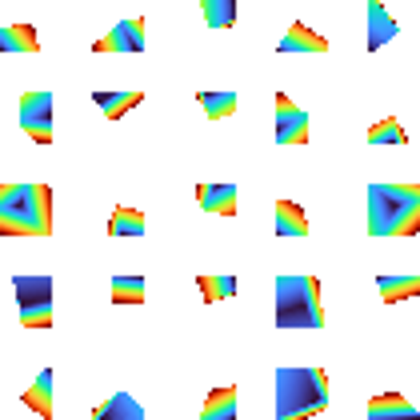

In [219]:
images = [b.get_depth_image(img[...,2]) for img in patches_centered[:25]]
b.viz.scale_image(b.hvstack_images(images, 5, 5),4.0)

In [220]:
test_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(1000),200), table_pose,  0.05, 1.0)
test_images = b.RENDERER.render_many(test_poses[:,None,...], jnp.array([IDX]))
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), test_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

In [221]:
def get_error_between_patches(slice_centered, patch):

    # far_mask_slice_centered = (slice_centered[...,2] > 10.0)[...,None]
    # far_mask_patch = (patch[...,2] > 10.0)[...,None]
    
    eps = 0.5
    far_mask_slice_centered =  ((1-slice_centered[...,3]) > eps)[...,None]
    far_mask_patch = ((1-patch[...,3]) > eps)[...,None]

    slice_centered = slice_centered[...,:3]
    patch = patch[...,:3]
    
    slice_centered = slice_centered * (1.0 - far_mask_slice_centered) + 1000.0 * far_mask_slice_centered
    patch = patch * (1.0 - far_mask_patch) + 1000.0 * far_mask_patch
    
    distances = jnp.linalg.norm(slice_centered - patch, axis=-1)
    width = 0.005
    probabilities_per_pixel = (distances > width/2)
    return probabilities_per_pixel.sum()


get_error_between_patches_parallel_patches = jax.vmap(get_error_between_patches, in_axes=(None, 0))


@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,),
)
def compute_error(ij, observed_xyz_padded, patch):
    slice = jax.lax.dynamic_slice(observed_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 4))
    # don't center slice, move patch to center pixel of slice instead?
    slice_centered = jnp.concatenate([slice[...,:3] - slice[filter_size, filter_size,:3], slice[...,3][...,None]], axis=-1)
    
    return get_error_between_patches(slice_centered, patch)
    #return get_error_between_patches(slice, patch)


def get_errors(observed_xyz, template):
    observed_xyz_padded = jax.lax.pad(observed_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    heatmap = compute_error(indices, observed_xyz_padded, template)
    return heatmap

    
get_errors_jit = jax.jit(get_errors)
get_errors_vmap_jit = jax.jit(jax.vmap(get_errors, in_axes=(None, 0)))

In [222]:
import matplotlib.colors as mcolors

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

# generate three side by side activation visualizations
# shape + activation, shape, and activation

def generate_heatmap_viz(observed_xyz, heatmaps):
    assert observed_xyz.shape[-1] == 4
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 3)
    
    original_image = observed_xyz[...,2]
    ax.imshow(b.preprocess_for_viz(original_image[filter_size:-filter_size,filter_size:-filter_size])) # cut off edges for filter
    
    best_idx = jnp.unravel_index(heatmaps.argmin(), heatmaps.shape)
    
    c_white = mcolors.colorConverter.to_rgba('white',alpha = 0)
    c_red= mcolors.colorConverter.to_rgba('red',alpha = 1)
    cmap_rb = mcolors.LinearSegmentedColormap.from_list('rb_cmap',[c_red,c_white],512)
    
    hmap = heatmaps[best_idx[0]]
    ax.imshow(hmap, cmap_rb, alpha=0.75)
    ax.axis('off')

    ax.scatter(best_idx[2], best_idx[1],color="black", marker='x', alpha=1) # plot the pose point 
    #ax.axis('off')
    
    ax2 = fig.add_subplot(1, 3, 1)
    ax2.axis('off')
    ax2.imshow(b.preprocess_for_viz(original_image[filter_size:-filter_size,filter_size:-filter_size])) # cut off edges for filter
    
    ax3 = fig.add_subplot(1, 3, 2)
    ax3.axis('off')
    ax3.imshow(hmap, cmap_rb)
    
    img_PIL = fig2img(fig)
    return img_PIL

18


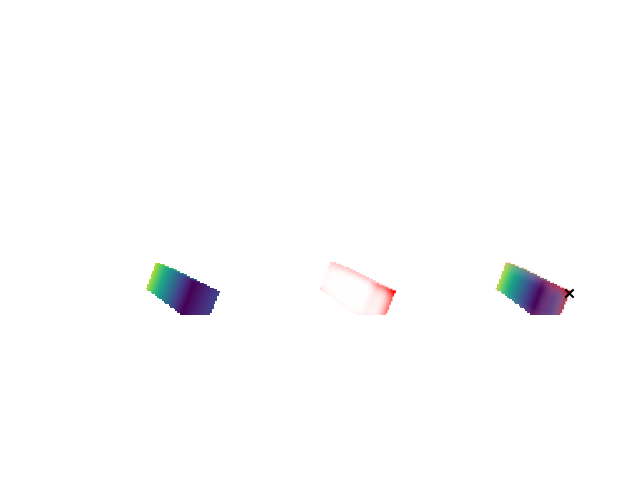

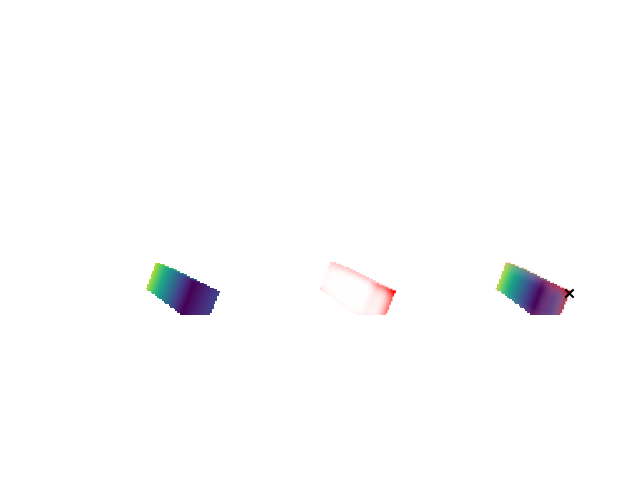

In [227]:
i = 25
observed_xyz = test_images[i]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
obs_mask = (observed_xyz[...,3][filter_size:-filter_size,filter_size:-filter_size]).astype(bool)
clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.max(heatmaps, axis=(1,2))[...,None,None]
print(clean_heatmap.min())
# visualize a single heatmap
generate_heatmap_viz(observed_xyz, clean_heatmap)

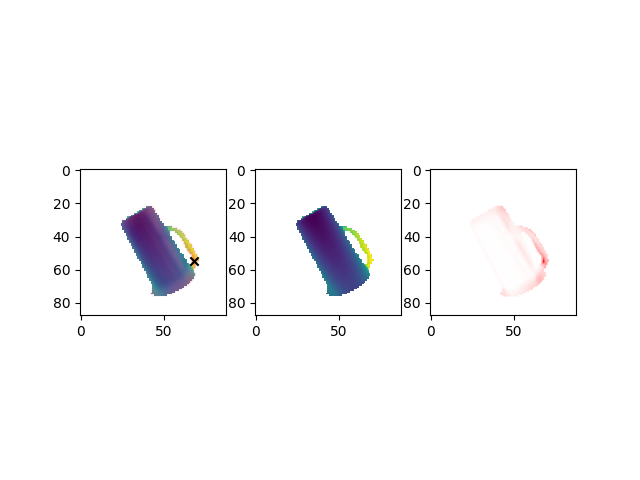

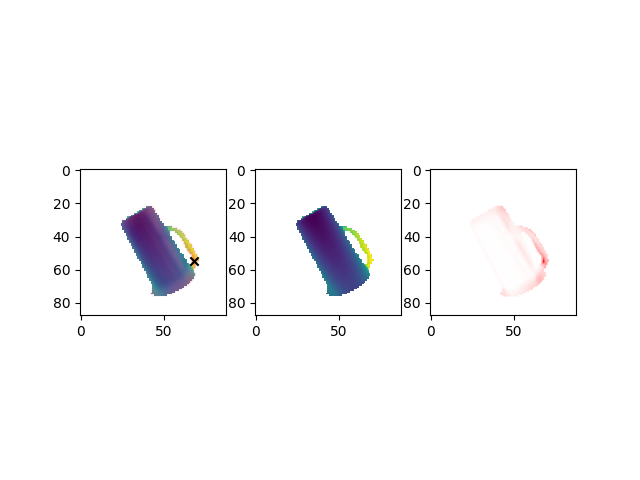

In [ ]:
# generate stack of heatmap images

heatmap_list = []
for observed_xyz in test_images:
    heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
    obs_mask = (observed_xyz[...,3][filter_size:-filter_size,filter_size:-filter_size]).astype(bool)
    clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.max(heatmaps, axis=(1,2))[...,None,None]
    heatmap_list.append(generate_heatmap_viz(observed_xyz, clean_heatmap))

In [ ]:
# make heatmap gif from stack

def make_gif_from_pil_images(images, filename):
    """Save a list of PIL images as a GIF.
    
    Args:
        images (list): List of PIL images.
        filename (str): Filename to save GIF to.
    """
    images[0].save(
        fp=filename,
        format="GIF",
        append_images=images[1:],
        save_all=True,
        duration=500,
        loop=0,
    )

make_gif_from_pil_images(heatmap_list, 'heatmap_video_masked.gif')